# In this code, we will incorporate to graphs to better understand price dynamic to show average value over the past 5 years for each type of house

In [1]:
# importing all dependencies (just in case)

import gmaps
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime
import seaborn as sns
from scipy.stats import linregress
from matplotlib import pyplot as plt
from config_Laura import (gkey2)

In [2]:
# Zillow has their datasets divided by how many bedrooms there are: importing all datasets, to then merge them and clean them
zillow_value_1 = pd.read_csv('Resources_Laura/zillow_value_1.csv')
zillow_value_2 = pd.read_csv('Resources_Laura/zillow_value_2.csv')
zillow_value_3 = pd.read_csv('Resources_Laura/zillow_value_3.csv')

In [3]:
# adding a column to show how many bedrooms, based on the dataset, so that it is clear once it is merged.
zillow_value_1['Bdrm'] = "1"
zillow_value_2['Bdrm'] = "2"
zillow_value_3['Bdrm'] = "3"

In [4]:
properties = pd.concat([zillow_value_1,zillow_value_2,zillow_value_3])

In [5]:
properties_ca = properties.loc[properties['State']=="CA"]

In [6]:
properties_ca.head(1)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/96,...,7/31/20,8/31/20,9/30/20,10/31/20,11/30/20,12/31/20,1/31/21,2/28/21,3/31/21,Bdrm
12,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,257591.0,...,867306,865503,864815,857989,852618,841552,833637,824861,820867,1


In [7]:
#transpose the dates, so that we can have the date as a value in a row, vs the column name. This will make a line trending easier to plot and read.
properties_ca_transposed = pd.melt(properties_ca, id_vars=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName','Bdrm'])
properties_ca_transposed.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Bdrm,variable,value
0,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,1,1/31/96,257591.0
1,96107,22,90250,Zip,CA,CA,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles County,1,1/31/96,182615.0
2,97771,40,94565,Zip,CA,CA,Pittsburg,San Francisco-Oakland-Hayward,Contra Costa County,1,1/31/96,NaN
3,96027,44,90046,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,1,1/31/96,119762.0
4,97711,88,94501,Zip,CA,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,1,1/31/96,132380.0


In [8]:
properties_ca_transposed = properties_ca_transposed.dropna()
properties_ca_transposed.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Bdrm,variable,value
0,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,1,1/31/96,257591.0
1,96107,22,90250,Zip,CA,CA,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles County,1,1/31/96,182615.0
3,96027,44,90046,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,1,1/31/96,119762.0
4,97711,88,94501,Zip,CA,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,1,1/31/96,132380.0
5,97565,94,94110,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,1,1/31/96,214062.0


In [9]:
properties_ca_transposed['variable']= pd.to_datetime(properties_ca_transposed['variable'])

In [10]:
#only select prices post 1/31/2014 to make it consistent with the remaining of our analysis
properties_ca_clean = properties_ca_transposed.loc[properties_ca_transposed['variable']>='1/31/2014']
properties_ca_clean = properties_ca_clean.rename(columns={'variable':'Date'})
properties_ca_clean.head(1)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Bdrm,Date,value
981504,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,1,2014-01-31,716780.0


In [11]:
properties_ca_clean.dtypes

RegionID               int64
SizeRank               int64
RegionName             int64
RegionType            object
StateName             object
State                 object
City                  object
Metro                 object
CountyName            object
Bdrm                  object
Date          datetime64[ns]
value                float64
dtype: object

### Boxplot:

In [12]:
# add year to dataframe
properties_ca_clean['year'] = properties_ca_clean['Date'].dt.strftime('%y')

In [23]:
#separate the dataset by room, to have a boxplot for each separate room
property_one = properties_ca_clean.loc[properties_ca_clean['Bdrm']=="1"]
property_two = properties_ca_clean.loc[properties_ca_clean['Bdrm']=="2"]
property_three = properties_ca_clean.loc[properties_ca_clean['Bdrm']=="3"]
len(property_three)


130363

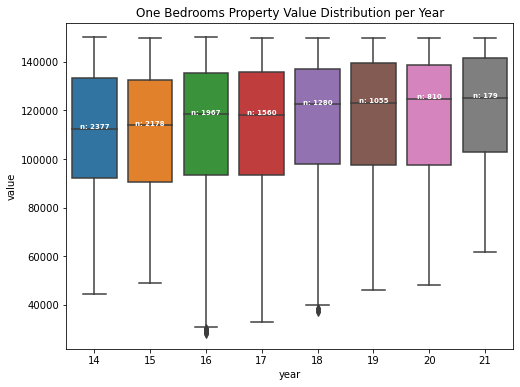

In [34]:
#plotting box and whisker
fig, ax = plt.subplots()
fig.set_size_inches((8,6))
sns.boxplot(x='year',y='value',data=property_one,ax=ax)
ax.set_title('One Bedrooms Property Value Distribution per Year')

medians = property_one.groupby(['year'])['value'].median().values
nobs = property_one['year'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.03,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')
plt.savefig("Resources_Laura/One Bedroom Property Value.png")
plt.show()

In [15]:
property_three

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Bdrm,Date,value,year
984399,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,3,2014-01-31,1513356.0,14
984400,96107,22,90250,Zip,CA,CA,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles County,3,2014-01-31,463066.0,14
984401,97771,40,94565,Zip,CA,CA,Pittsburg,San Francisco-Oakland-Hayward,Contra Costa County,3,2014-01-31,272226.0,14
984402,96027,44,90046,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,3,2014-01-31,804685.0,14
984403,97711,88,94501,Zip,CA,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,3,2014-01-31,737525.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376826,97306,33985,93519,Zip,CA,CA,Mojave,Bakersfield,Kern County,3,2021-03-31,194385.0,21
1376827,98589,34007,96061,Zip,CA,CA,Mill Creek,Red Bluff,Tehama County,3,2021-03-31,208199.0,21
1376828,98009,34027,95141,Zip,CA,CA,San Jose,San Jose-Sunnyvale-Santa Clara,Santa Clara County,3,2021-03-31,1472493.0,21
1376829,98152,34322,95375,Zip,CA,CA,Strawberry,Sonora,Tuolumne County,3,2021-03-31,358041.0,21


### Ridgeline plot

In [16]:
from joypy import joyplot

In [48]:
property_one = property_one.loc[property_one['value']<=150000]

<Figure size 432x288 with 0 Axes>

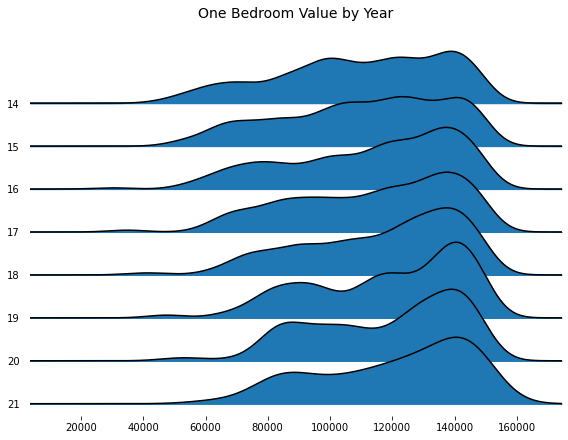

In [50]:
plt.figure()

joyplot(
    data=property_one[['year', 'value']], 
    by='year',
    figsize=(8, 6)
)
plt.title('One Bedroom Value by Year', fontsize=14)
plt.savefig("Resources_Laura/One Bedroom Property Value Distribution.png")
plt.show()